In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
# from librosa import output
import os
import sys
sys.path.append(os.path.abspath('../src'))

In [2]:
file = open('/home/faaira/Downloads/file.txt','r')
x = []
fs = 16000
for lines in file:
    points = lines.split(",")
    for point in points:
        x.append(float(point))

Text(0.5, 1.0, 'Input cough signal')

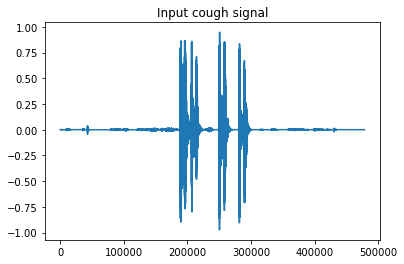

In [11]:
#Visualize cough signal
#file = "/home/faaira/Desktop/new_data/public_dataset/0a0b83e9-860d-42ec-855b-49e73c5ad49e.wav"
file = "/home/faaira/Desktop/new_data/wav_files/0a1b2f0a-afa2-42e3-9e60-998c4bdf1f95.wav"
x,fs = librosa.load(file, sr=None)
plt.plot(x)
plt.title("Input cough signal")

In [12]:
import numpy as np

#Use old segmentation
def segment_cough(x,fs, cough_padding=0.9,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

[False False False ... False False False]
[array([ 2.8991699e-03,  3.4179688e-03,  3.6621094e-03, ...,
       -3.0517578e-05, -3.0517578e-05, -6.1035156e-05], dtype=float32), array([0.00137329, 0.00119019, 0.0012207 , ..., 0.12350464, 0.11401367,
       0.10345459], dtype=float32), array([-1.1260986e-02, -5.6762695e-03,  6.1035156e-05, ...,
       -3.0517578e-05, -3.0517578e-05, -3.0517578e-05], dtype=float32)]


Text(0.5, 1.0, 'Segmentation Output')

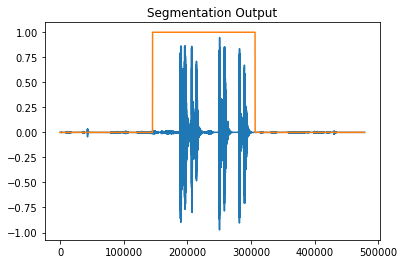

In [13]:
cough_segments, cough_mask = segment_cough(np.asarray(x),fs)
print(cough_mask)
print(cough_segments)
plt.plot(x)
plt.plot(cough_mask)
plt.title("Segmentation Output")

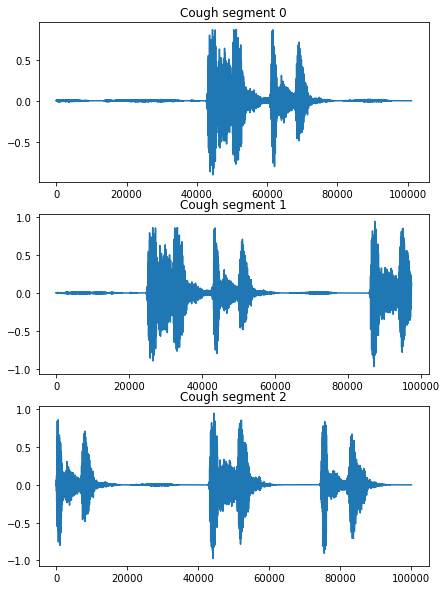

In [14]:
fig, axs = plt.subplots(len(cough_segments),1, figsize=(7,10))
for i in range(0,len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment " + str(i))

Text(0.5, 1.0, 'Segmentation Output')

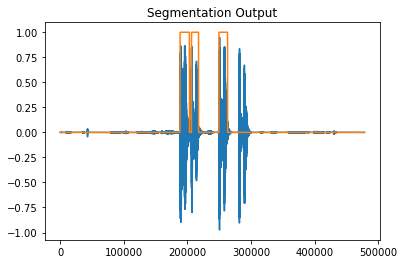

In [15]:
cough_segments, cough_mask = segment_cough(x,fs, cough_padding=0)
plt.plot(x)
plt.plot(cough_mask)
plt.title("Segmentation Output")

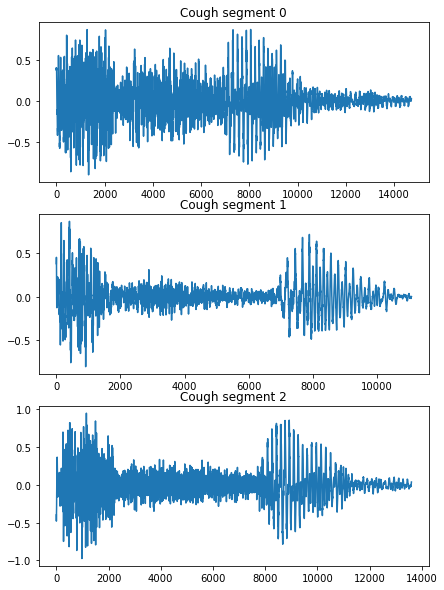

In [16]:
fig, axs = plt.subplots(len(cough_segments),1, figsize=(7,10))
for i in range(0,len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment " + str(i))

In [8]:
def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR

In [9]:
snr = compute_SNR(x,fs)
print("The SNR of the cough signal is {0}".format(snr))

The SNR of the cough signal is 37.843148708343506


In [10]:
alpha = np.concatenate((cough_segments[0] , cough_segments[1], cough_segments[2]))

In [11]:
# file = np.stack ([cough_segments[0], cough_segments[1], cough_segments[2]], )

In [12]:
import soundfile as sf
sf.write('stereo1_file.wav', alpha, 44100, 'PCM_24')
# librosa.output.write_wav('file_trim_5s.wav', file, sr)